1. Import Required Libraries

In [1]:
import os
import random
import sys
import argparse


# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim


# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import Dataset, DataLoader

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

#from models import Model
#from datasets import get_data_loaders
#from train import train
#from test import evaluate, load_model

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


2. Set the Hyperparameters

In [2]:
# Paths to real and fake image directories
train_real_path = r"D:\Projects\SP CUP Dataset\valid\real" # r is because of the backslash causing \p 
train_fake_path = r"D:\Projects\SP CUP Dataset\valid\fake" # to be interpreted as a special character

test_real_path = r"D:\Projects\SP CUP Dataset\Small train\real"
test_fake_path = r"D:\Projects\SP CUP Dataset\Small train\fake"

BATCH_SIZE = 32 # Batch size for training

3. Set dataset folders for training

In [3]:
# Get the image filenames
train_real_count = len(os.listdir(train_real_path))
train_fake_count = len(os.listdir(train_fake_path))

test_real_count = len(os.listdir(test_real_path))
test_fake_count = len(os.listdir(test_fake_path))

print(f"Train Real images: {train_real_count}, Train Fake images: {train_fake_count}")
print(f"Test Real images: {test_real_count}, Test Fake images: {test_fake_count}")

Train Real images: 1548, Train Fake images: 1524
Test Real images: 20, Test Fake images: 20


4. Preparing the Datasets

4.1 Training Data

In [4]:
#Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit

# Get the image filenames
train_real_images = os.listdir(train_real_path)
train_fake_images = os.listdir(train_fake_path)

# Apply the limit
train_real_images = train_real_images[:min(MAX_SAMPLES_PER_CLASS, len(train_real_images))]
train_fake_images = train_fake_images[:min(MAX_SAMPLES_PER_CLASS, len(train_fake_images))]

# Combine and label the dataset
train_balanced_dataset = [(os.path.join(train_real_path, img), 0) for img in train_real_images] + \
                   [(os.path.join(train_fake_path, img), 1) for img in train_fake_images]

# Shuffle the dataset
random.shuffle(train_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(train_balanced_dataset)} (Real: {len(train_real_images)}, Fake: {len(train_fake_images)})")


Total dataset size: 3072 (Real: 1548, Fake: 1524)


4.2 Testing Data

In [5]:
#Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit

# Get the image filenames
test_real_images = os.listdir(test_real_path)
test_fake_images = os.listdir(test_fake_path)

# Apply the limit
test_real_images = test_real_images[:min(MAX_SAMPLES_PER_CLASS, len(test_real_images))]
test_fake_images = test_fake_images[:min(MAX_SAMPLES_PER_CLASS, len(test_fake_images))]

# Combine and label the dataset
test_balanced_dataset = [(os.path.join(test_real_path, img), 0) for img in test_real_images] + \
                   [(os.path.join(test_fake_path, img), 1) for img in test_fake_images]

# Shuffle the dataset
random.shuffle(test_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(test_balanced_dataset)} (Real: {len(test_real_images)}, Fake: {len(test_fake_images)})")


Total dataset size: 40 (Real: 20, Fake: 20)


5. Visualize the dataset

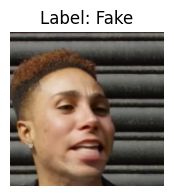

Image file name: train_fake_0000089.png
Image Shape: (256, 256)


In [6]:
# Load the first image from the balanced dataset
image_path, label = train_balanced_dataset[0]
image_path, label = test_balanced_dataset[0]

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure(figsize=(2, 2))  # Adjust the figsize to make the image smaller
plt.imshow(image)
plt.title(f"Label: {'Real' if label == 0 else 'Fake'}")
plt.xlabel(os.path.basename(image_path))  # Display the image name
plt.axis('off')  # Hide the axis
plt.show()

# Display the image file name after the image
print(f"Image file name: {os.path.basename(image_path)}")
print(f"Image Shape: {image.size}")

5.1 Plot more Images

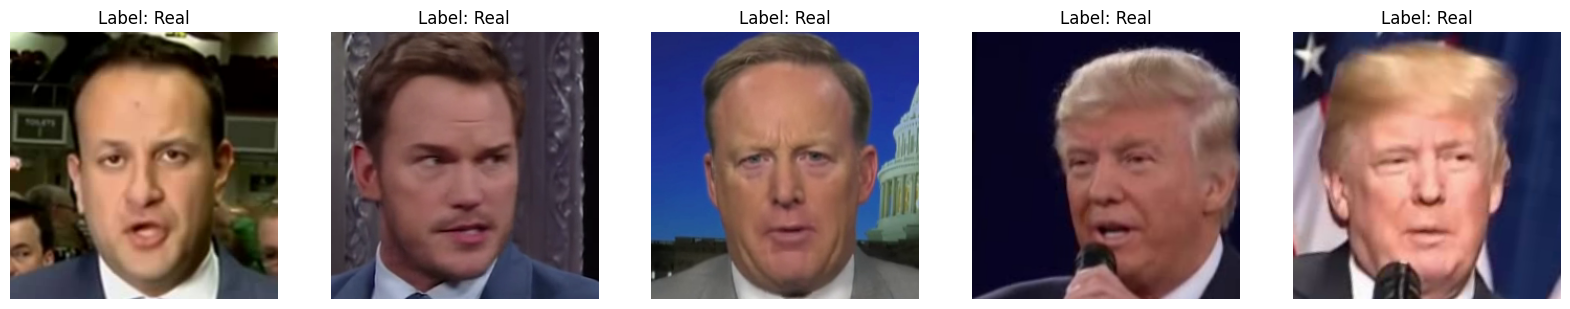

Image file name: valid_real_0718788.png
Image file name: valid_real_0899913.png
Image file name: valid_real_0783769.png
Image file name: valid_real_0372053.png
Image file name: valid_real_0056262.png


In [7]:
# Set the random seed for reproducibility
random.seed(42)

# Randomly select 5 images from the balanced dataset
selected_indices = random.sample(range(len(train_balanced_dataset)), 5)
balanced_dataset5_1 = train_balanced_dataset
#selected_indices = random.sample(range(len(test_balanced_dataset)), 5)
# balanced_dataset5_1 = test_balanced_dataset


# Display 5 images in a row
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset5_1[idx]
    image = Image.open(image_path)
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Real' if label == 0 else 'Fake'}")
    axes[i].set_xlabel(os.path.basename(image_path))  # Display the image name
    axes[i].axis('off')  # Hide the axis

plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset5_1[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    

6. Getting the datasets ( Setup training data)

In [8]:
# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()  # Call the parent class's init method
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Define transforms
transform = transforms.Compose([
    Resize((128, 128)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#Create the dataset
train_data = ImageDataset(train_balanced_dataset, 
                          transform=transform)

#Create the dataset
test_data = ImageDataset(test_balanced_dataset, 
                          transform=transform)

7. Visualize train_data and labels

In [9]:
print(len(train_data)) 
print(len(test_data))

image, label = train_data[700] # Label is 1
#image, label = train_data[1600] # Label is 0
print(image.shape, label)

# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {[label]}")

3072
40
torch.Size([3, 128, 128]) 1
Image shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image label: [1]


7.1 Checking Labels of more data

In [10]:
# Set the random seed for reproducibility
random.seed(42)
#dataset = train_data
dataset = test_data


# Select 50 random images
selected_indices = random.sample(range(len(dataset)), 10)

# Print the shape of images and labels of 50 random images
for idx in selected_indices:
    image, label = dataset[idx]
    image_path, _ = dataset.data[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    print(f"Image shape: {image.shape}, Label: {label}")

Image file name: train_fake_0000035.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_fake_0000062.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_real_0000421.png
Image shape: torch.Size([3, 128, 128]), Label: 0
Image file name: train_fake_0000115.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_real_0000393.png
Image shape: torch.Size([3, 128, 128]), Label: 0
Image file name: train_fake_0000112.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_fake_0000074.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_real_0000341.png
Image shape: torch.Size([3, 128, 128]), Label: 0
Image file name: train_fake_0000098.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_fake_0000034.png
Image shape: torch.Size([3, 128, 128]), Label: 1


7.2 Visualize our data

Image shape: torch.Size([3, 128, 128])


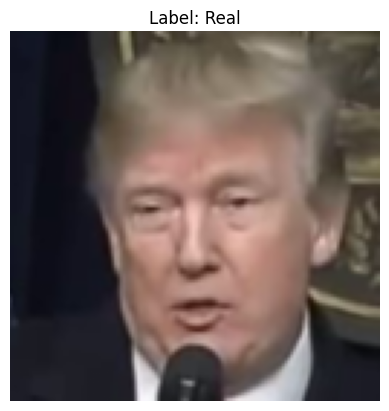

In [11]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
# Unnormalize the image
# We have to use the relevant mean and std values for this
plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize the image
plt.title(f"Label: {'Real' if label == 0 else 'Fake'}")
plt.axis('off')
plt.show()

7.3 Visualize more data

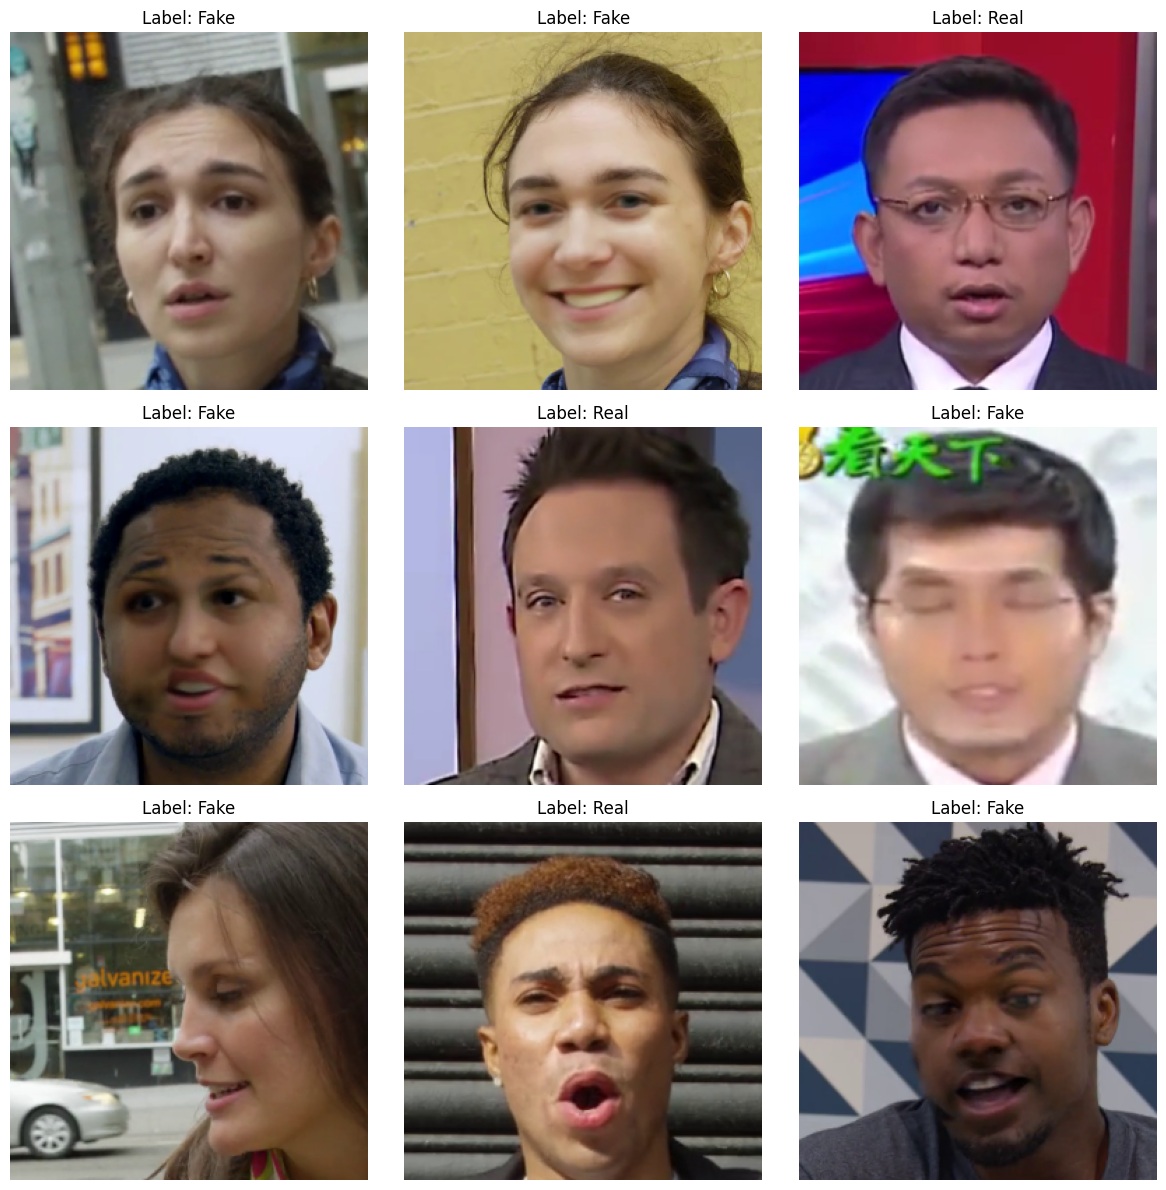

Image file name: train_fake_0000035.png
Image file name: train_fake_0000062.png
Image file name: train_real_0000421.png
Image file name: train_fake_0000115.png
Image file name: train_real_0000393.png
Image file name: train_fake_0000112.png
Image file name: train_fake_0000074.png
Image file name: train_real_0000341.png
Image file name: train_fake_0000098.png


In [12]:
# Set the random seed for reproducibility
random.seed(42)
balanced_dataset7_3 = train_balanced_dataset
balanced_dataset7_3 = test_balanced_dataset

# Randomly select 9 images from the balanced dataset
selected_indices = random.sample(range(len(balanced_dataset7_3)), 9)

# Display 9 images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset7_3[idx]
    image = Image.open(image_path)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Label: {'Real' if label == 0 else 'Fake'}")
    ax.set_xlabel(os.path.basename(image_path))  # Display the image name
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset7_3[idx]
    print(f"Image file name: {os.path.basename(image_path)}")

In [13]:
train_data

In [14]:
#Calculate the mean and std of the dataset

8. Prepare DataLoader

In [15]:
# Create the DataLoader
train_dataloader = DataLoader(train_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=True)

test_dataloader = DataLoader(test_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=True)

# Example: Iterate through the DataLoader
for images, labels in test_dataloader:
    print(images.shape, labels.shape)
    break

print(images[0].shape)
train_dataloader, test_dataloader

torch.Size([32, 3, 128, 128]) torch.Size([32])
torch.Size([3, 128, 128])


(<torch.utils.data.dataloader.DataLoader at 0x1edad9f0cb0>,
 <torch.utils.data.dataloader.DataLoader at 0x1edab90bcb0>)

8.1 Check what we have created

In [16]:
# Let's check out what what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(test_dataloader)}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001EDAD9F0CB0>, <torch.utils.data.dataloader.DataLoader object at 0x000001EDAB90BCB0>)
Length of train_dataloader: 96 batches of 32... = 3072
Length of test_dataloader: 2 batches of 32... = 64


8.2 What's inside the dataloaders

In [17]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

9. Building a baseline Model

In [18]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 16384]) -> [color_channels, height*width]


9.1 Modelv0